## Import packages

In [1]:
import gc
import os

import audiomentations as A
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch

from scipy import signal
from torch.utils.data import Dataset
from nnAudio.Spectrogram import CQT # CQT is an alias of CQT1992v2
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
ROOT_DIR = '../data/input/'
df = pd.read_csv(os.path.join(ROOT_DIR, 'training_labels.csv'))
df['path'] = df['id'].apply(lambda x: f'{ROOT_DIR}/train/{x[0]}/{x[1]}/{x[2]}/{x}.npy')
df.head(3)

,id,target,path
0,00000e74ad,1,../data/input//train/0/0/0/00000e74ad.npy
1,00001f4945,0,../data/input//train/0/0/0/00001f4945.npy
2,0000661522,0,../data/input//train/0/0/0/0000661522.npy


In [3]:
x = np.load(df.path[0])[0]
print(x.shape)

(4096,)


## STFT

(65, 129)


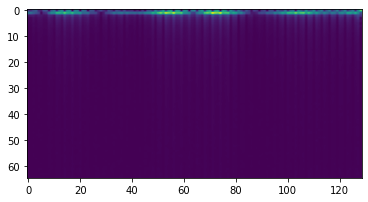

In [11]:
def get_stft(signal):
    return torch.stft(torch.Tensor(signal), n_fft=128, return_complex=True, normalized=True).abs().numpy()

y = get_stft(x)
print(y.shape)
plt.imshow(y)

## CQT

(40, 129)


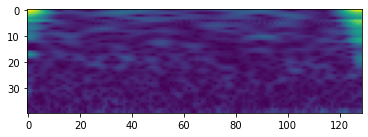

In [14]:
def get_cqt(signal):    
    return np.abs(librosa.cqt(signal, sr=2048, hop_length=32, n_bins=40, bins_per_octave=12))    

y = get_cqt(x)
print(y.shape)
plt.imshow(y)

## DWT

In [6]:
import torch
from pytorch_wavelets import DWT1DForward

In [16]:
dwt = DWT1DForward(wave='db6', J=3)
yl, yh = dwt(torch.tensor(x.reshape(1, 1, -1).astype('float32')))

print(yl.shape)
print(yh[0].shape)
print(yh[1].shape)
print(yh[2].shape)

torch.Size([1, 1, 521])
torch.Size([1, 1, 2053])
torch.Size([1, 1, 1032])
torch.Size([1, 1, 521])


## CWT

(9, 4096)


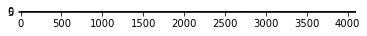

In [18]:
def get_cwt(signal):
    return np.abs(scipy.signal.cwt(signal, scipy.signal.morlet, np.arange(1, 10)))

y = get_cwt(x)
print(y.shape)
plt.imshow(y)

In [48]:
dt = 32         # sampling frequency
dj = 0.2       # scale distribution parameter

spec = WaveletTransformTorch(dt, dj)
y = spec.power(torch.tensor([x.astype('float32')])).numpy()

print(y.shape)

(56, 4096)


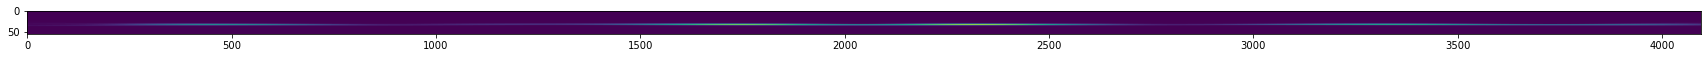

In [49]:
plt.figure(figsize=(30, 15))
plt.imshow(y)

## Define dataset

Let's define a dataset to work with.

In [2]:
class G2NetDataset(Dataset):
    def __init__(self, paths, targets=None): 
        self.paths = paths
        self.targets = targets

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):      
        signal = np.load(self.paths[index])
        signal = np.concatenate(signal, axis=0) # we concatenate data from 3 sensors to one signal
        signal = signal / np.max(signal)
        if self.targets is not None:
            targets = self.targets[index]
            return {
                "signal": torch.tensor(signal, dtype=torch.float),
                "target": torch.tensor(targets, dtype=torch.long),
            }
        else:
            return {
                'signal': torch.tensor(signal, dtype=torch.float)
            }

## Demonstrate CQT usage

nnAudio has several implementations of CQT; we will use the recommended one - CQT1992v2 (see https://github.com/KinWaiCheuk/nnAudio/blob/master/Installation/nnAudio/Spectrogram.py for details). You can simply call CQT, since it's an alias of CQT1992v2. If you want other CQT version, you'll have to import it directly.

Let's calculate CQT for 4 first signals.

In [12]:
transform = CQT(sr=2048,        # sample rate
                fmin=20,        # min freq
                fmax=1024,      # max freq
                hop_length=32)  # hop length

ds = G2NetDataset(df['path'], df['target'])
cqts = []
for i in range(4):
    cqts.append(transform(ds.__getitem__(i)['signal']).squeeze())

CQT kernels created, time used = 0.0119 seconds


In [13]:
cqts[0].shape

torch.Size([69, 385])

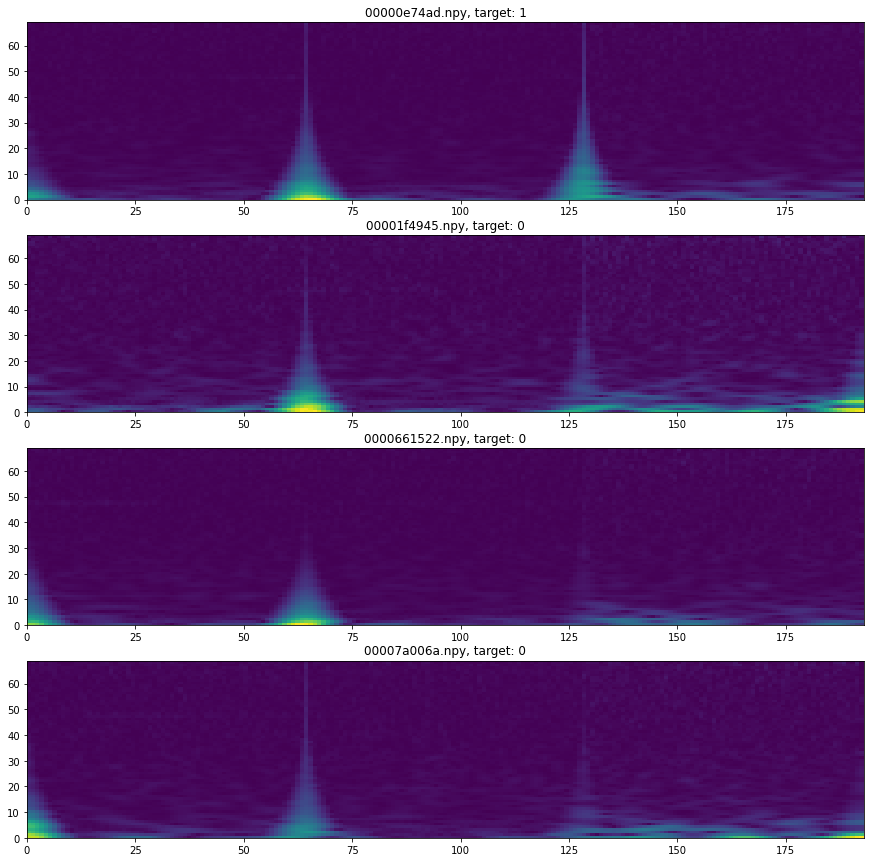

In [5]:
fig, axs = plt.subplots(4)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(4):
    nid = df['id'][i]
    ntarget = df['target'][i]
    axs[i].title.set_text(f'{nid}.npy, target: {ntarget}')
    axs[i].pcolormesh(cqts[i])

You can use CQT1992v2() as your model block to convert waves to CQT on-the-fly.

## Bandpass filter

In [39]:
sr = 2048
fp = 500


In [40]:
def bandpass(x, sr, fp, fs, gpass, gstop):
    fn = sr / 2
    wp = fp / fn
    ws = fs / fn
    N, Wn = signal.buttord(wp, ws, gpass, gstop)
    b, a = signal.butter(N, Wn, btype="bandpass", fs=sr)
    y = signal.filtfilt(b, a, x)
    return y

In [41]:
# bHP, aHP = signal.butter(8, (20, 500), btype="bandpass", fs=2048)

# def filterSig(wave, a=aHP, b=bHP):
#     """Apply a 20Hz high pass filter to the three events"""
#     return signal.filtfilt(b, a, wave)

In [28]:
x = np.load(df.path.values[0])[0]
x = (x - 4.3110074e-26) / 6.1481726e-21
y = filterSig(x)

(0.0, 0.02)

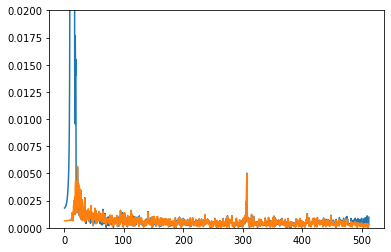

In [36]:
n_freq = 1024

F = np.fft.fft(x)
freq = np.fft.fftfreq(len(x), d=1/2048)
amp = np.abs(F/(len(x)/2))
plt.plot(freq[1: n_freq], amp[1: n_freq])

F = np.fft.fft(y)
freq = np.fft.fftfreq(len(x), d=1/2048)
amp = np.abs(F/(len(x)/2))
plt.plot(freq[1: n_freq], amp[1: n_freq])

plt.ylim(0, 0.02)

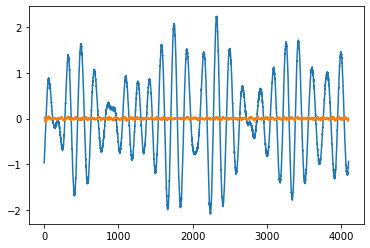

In [38]:
plt.plot(x)
plt.plot(y)

In [26]:
trans = A.BandPassFilter(
        min_center_freq=20.0,
        max_center_freq=500.0,
        min_q=1.0,
        max_q=2.0,
        p=1.0,
)
z = trans(x[0], sample_rate=2048)

/opt/conda/lib/python3.7/site-packages/audiomentations/core/transforms_interface.py:58: UserWarning: Warning: input samples have np.float64 dtype. Converting to np.float32...
  "Warning: input samples have np.float64 dtype. Converting to np.float32..."


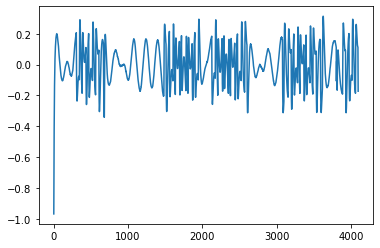

In [27]:
plt.plot(z)

In [29]:
(z - y[0]).mean()

0.0008958682409268494